In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy
from itertools import repeat

<Figure size 1000x800 with 0 Axes>

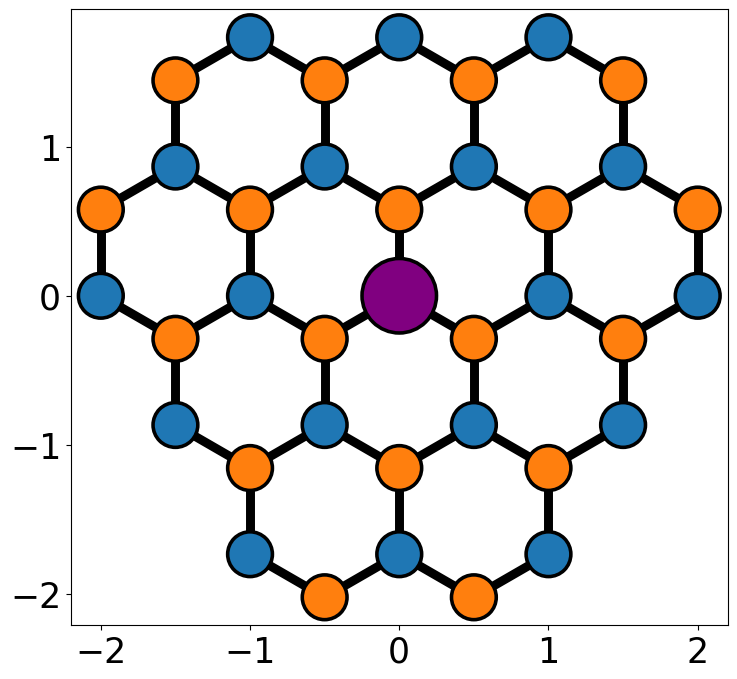

<Figure size 640x480 with 0 Axes>

In [2]:
import DEDlib
radius,colorbnd,imp,nd=[1.5,2.3,3.1,4.042,5.1],[7,19,37,61,91],[3,9,18,30,45],np.zeros((5,4),dtype = 'float')
psi2,SPG2,eig,SPrho0=DEDlib.GrapheneAnalyzer(imp[1],DEDlib.Graphenecirclestruct(radius[1],1),colorbnd[1],'GrapheneCirc'+str(radius[1])+'r')

In [65]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma):
    H = 0
    for i in range(2):
        H += impenergy * (c[i].dag() * c[i])
        for j in range(len(bathenergy)):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])
            H += bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    error=False
    try:
        exp = np.dot(H.eigenstates()[1][0].dag(), np.dot(n, H.eigenstates()[1][0]))
    except np.linalg.LinAlgError:
        error=True
        exp=0
    except ValueError:
        error=True
        exp=0
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])
    H += -Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H,exp,error

def MBGAIM(omega, H, c, eta):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    evals, evecs =scipy.linalg.eigh(H.data.toarray())
    vecn=np.conj(evecs[:,1:]).T
    exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
    return sum([abs(expi)** 2 / (omega + evals[i+1] - evals[0] + 1.j * eta) + 
                      abs(exp2[i])** 2 / (omega + evals[0] - evals[i+1] + 1.j * eta) for i,expi in enumerate(exp)])

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    H,exp2,error = HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma)
    print("--- %s s first part %d---" % ((time.time() - start_time) ,attempts), end='\r')
    if not error:
        eigs=H.eigenstates()
        exp = np.dot(eigs[1][0].dag(), np.dot(n, eigs[1][0]))
        if np.round(exp)==np.round(exp2):
            reset=True
            print("--- %s s second part %d---" % ((time.time() - start_time) ,attempts), end='\r')
            MBG = MBGAIM(omega, H, c, eta)
        return MBG,reset
    else:
        return MBG,reset

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=eig[select[i]]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

In [66]:
posimp=9

index=[]
for i in range(len(eig)):
    index.append(i)
omega= np.linspace(-8,8,4001)
N=2000
Ut=[3]
Sigma=[1.5]
#Ut=[1.5,3,9,12]
#Sigma=[0.75,1.5,4.5,6]
poles=4
lattice_length = 2+2*(poles-1)
c = []
for i in range(lattice_length):
    c.append(jordan_wigner_transform(i, lattice_length))
FinSigmadat=np.full((len(Ut), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
n=0
for i in range(lattice_length):
    n+=c[i].dag()*c[i]
for l in range(len(Ut)):
    AvgSigmadat=np.zeros(len(omega))
    for i in tqdm(range(N)):
        start_time = time.time()
        attempts=0
        reset=False
        while not reset:
            select=sorted(np.random.choice(index, poles,p=psi2,replace=False))
            NewM=startrans(poles,select,0,0)
            bathenergy=[]
            impengergy=NewM[0][0]
            for k in range(len(NewM)-1):
                bathenergy.append(NewM[k+1][k+1])
            Vkk=NewM[0,1:]
            eta=0.02*abs(omega)+0.000000000000000000000001
            MBGdat,reset=AIMsolver(impengergy, bathenergy, Vkk, Ut[l],Sigma[l],omega,eta,c,reset)
            NewSigmadat=1/nonintG(omega,eta,eig[select])-1/MBGdat+Sigma[l]
            if np.isnan(NewSigmadat).any() or any(float(i) >= 1000 for i in np.real(NewSigmadat)) or any(float(i) >= 500 for i in np.abs(NewSigmadat)):
                reset=False
            attempts+=1
        AvgSigmadat=AvgSigmadat+NewSigmadat/N
        print("--- %s %s---" % (AvgSigmadat[2000]*N/(i+1),NewSigmadat[2000]), end='\r')#Sigma[l])
    print(AvgSigmadat[2000])

  0%|          | 0/2000 [00:00<?, ?it/s]

(1.5158529687521016-2.281718765041706e-07j)07j) (2.1166080884295684-1.2181359817077818e-25j)----)---


In [67]:
finalG=1/(1/SPG2-AvgSigmadat+AvgSigmadat[2000])
FinSigmadat[0]=-np.imag(finalG)/np.pi

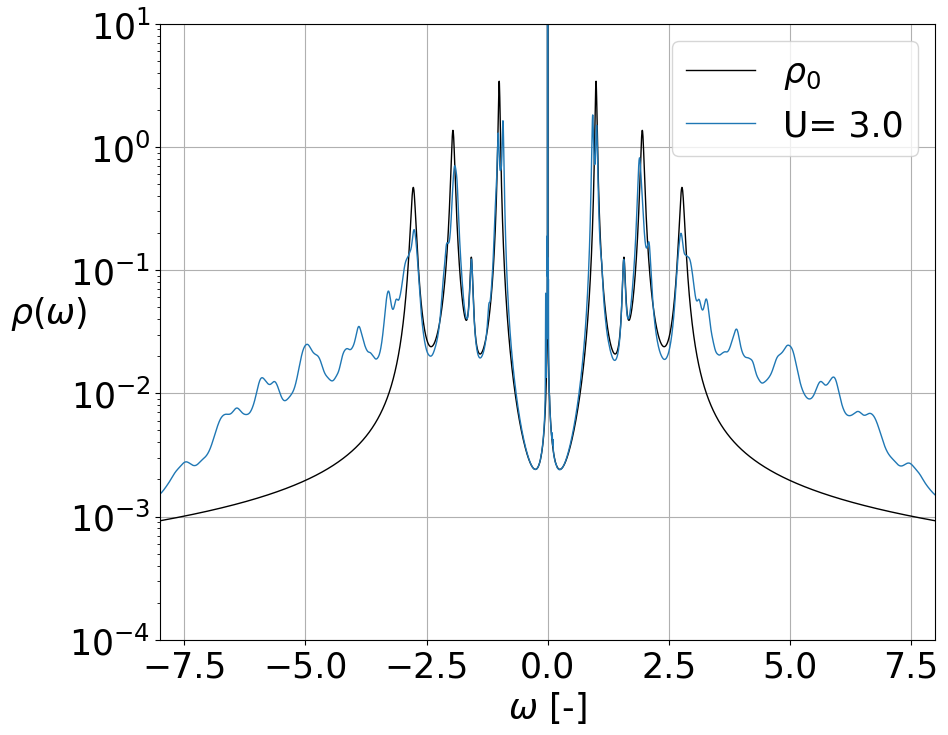

In [68]:
DOS3=-np.imag(SPG2)/np.pi
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=10)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
#for i in range(len(Ut)-1):
#   plt.plot(omega,FinSigmadat[i],label='U= %.1f'%Ut[i],linewidth=1)
plt.plot(omega,FinSigmadat[0],label='U= %.1f'%Ut[0],linewidth=1)
plt.legend()

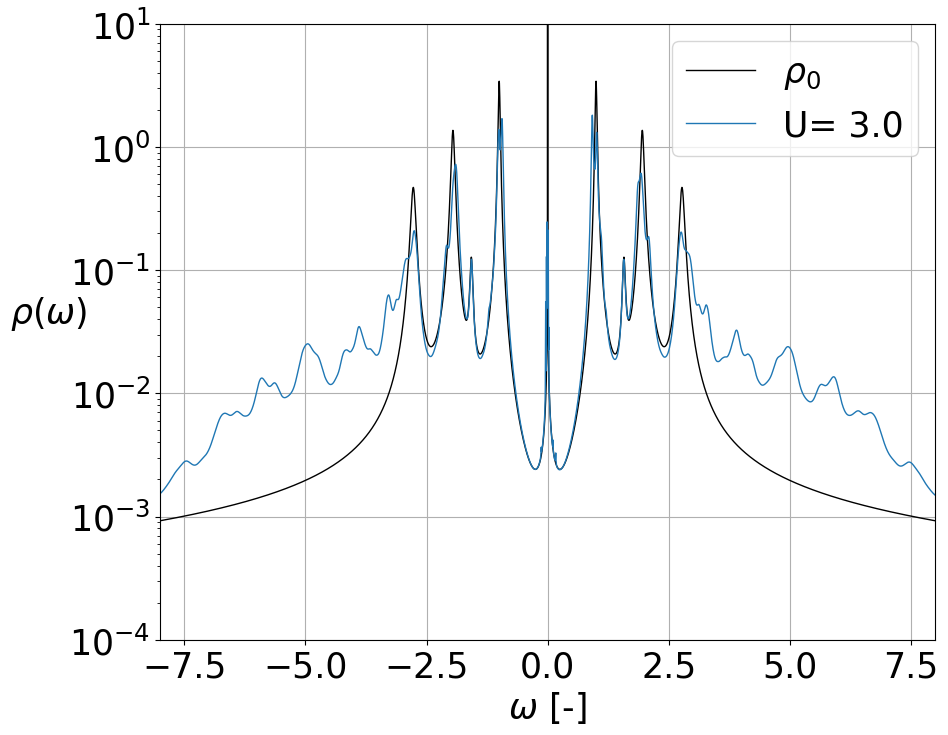

In [52]:
DOS3=-np.imag(SPG2)/np.pi
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=10)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
#for i in range(len(Ut)-1):
#   plt.plot(omega,FinSigmadat[i],label='U= %.1f'%Ut[i],linewidth=1)
plt.plot(omega,FinSigmadat[0],label='U= %.1f'%Ut[0],linewidth=1)
plt.legend()

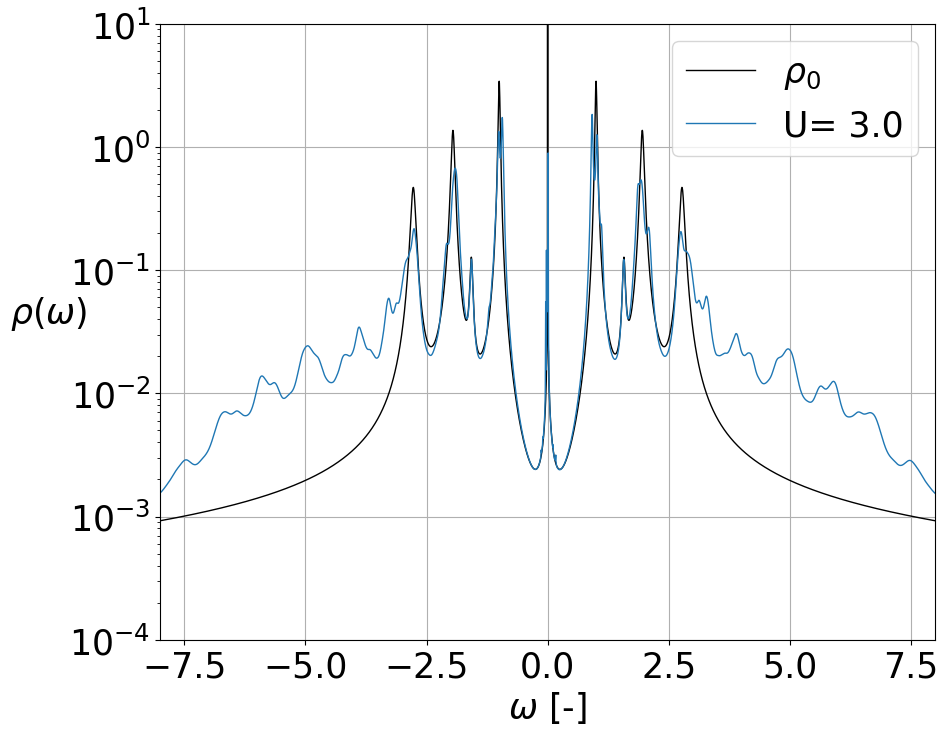

In [47]:
DOS3=-np.imag(SPG2)/np.pi
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=10)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
#for i in range(len(Ut)-1):
#   plt.plot(omega,FinSigmadat[i],label='U= %.1f'%Ut[i],linewidth=1)
plt.plot(omega,FinSigmadat[0],label='U= %.1f'%Ut[0],linewidth=1)
plt.legend()

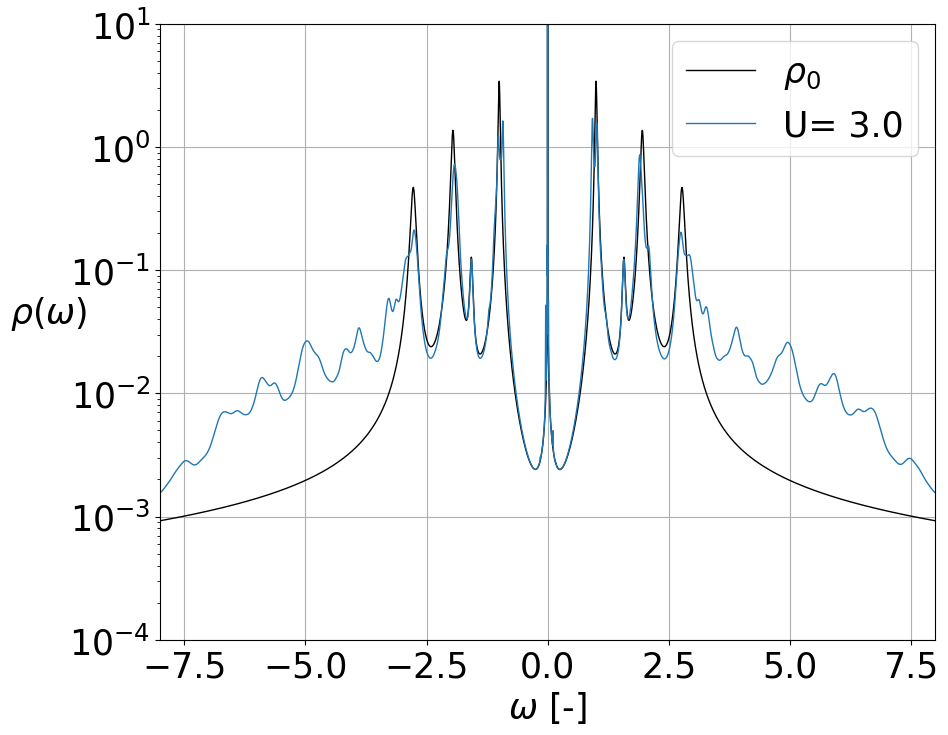

In [43]:
DOS3=-np.imag(SPG2)/np.pi
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=10)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
#for i in range(len(Ut)-1):
#   plt.plot(omega,FinSigmadat[i],label='U= %.1f'%Ut[i],linewidth=1)
plt.plot(omega,FinSigmadat[0],label='U= %.1f'%Ut[0],linewidth=1)
plt.legend()

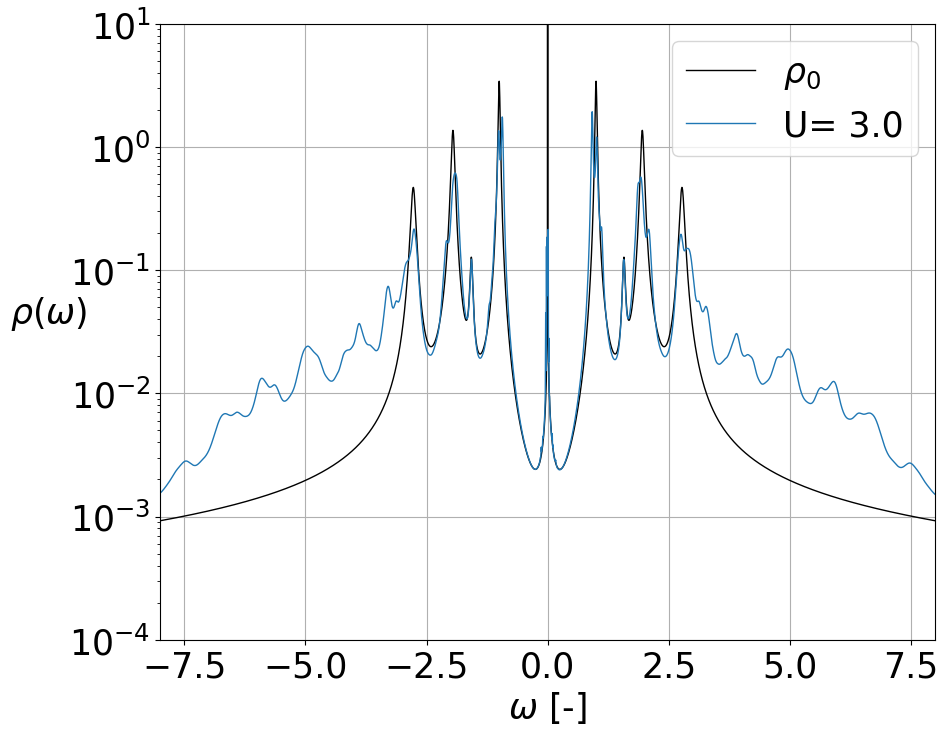

In [39]:
DOS3=-np.imag(SPG2)/np.pi
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=10)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
#for i in range(len(Ut)-1):
#   plt.plot(omega,FinSigmadat[i],label='U= %.1f'%Ut[i],linewidth=1)
plt.plot(omega,FinSigmadat[0],label='U= %.1f'%Ut[0],linewidth=1)
plt.legend()

In [6]:
FinSigmadat=np.real(FinSigmadat)
FinSigmadat2=[omega,DOS3[posimp],FinSigmadat[0],FinSigmadat[1],FinSigmadat[2],FinSigmadat[3]]

np.savetxt('DOS_AIMGraphener=15Uncv3',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DOS_AIMGraphener=15Uncv3", "r")
lines = text_file.read().split('\n')
for i in range(len(lines)-1):
    lines[i]=lines[i].split('\t')
    for j in range(2):
        lines[i][j]=float(lines[i][j])
print(lines[0])
text_file.close()

[-8.0, 0.0009238373553118786, '0.000994134859105353947', '0.00128942968822104279', '0.00192744573863232313', '0.00277582770930142686']
